$\newcommand\norm[1]{\lVert#1\rVert}$
$\newcommand\b[1]{\textbf{#1}}$

# Leading Order Behavior

The term "leading order behavior" refers to the leading coefficient on the complexity of an algorithm.

A lot of the time, people are only interested in the big-O behavior of an algorithm. The big-O behavior is useful, but the leading coefficient makes a difference, too. For example, $n^2$ and $100n^2$ are both $O(n^2)$, but obviously one is much bigger than the other.

In this notebook, we're going to walk through and example that illustrates the importance of the leading coefficient in terms of floating point operations (FLOPs) and execution time.

## First, Some Definitions

**Definition 1** Let $S$ be either $\mathbb{R}$ or $\mathbb{Z}^+$ and let $f : S \rightarrow \mathbb{R}$ and $g : S \rightarrow \mathbb{R}$. We say that $f(n)$ is _asymptotically equivalent_ to $g(n)$, denoted $f(n) \sim g(n)$ as $n \rightarrow \infty$ if 

$$\lim_{n \rightarrow \infty} \frac{f(n)}{g(n)} = 1$$

Notationally, we often drop the $n \rightarrow \infty$ part and just write $f(n) \sim g(n)$. An example of this would be $3n^2 - n + 1 \sim 3n^2$, because 

$$\lim_{n \rightarrow \infty} \frac{3n^2 - n + 1}{3n^2} = \lim_{n \rightarrow \infty} 1 - \frac{1}{3n} + \frac{1}{3n^2} = 1$$

Note that the leading coefficient makes a difference here, which is different from big-O. For example, $3n^2 \in O(n^2)$, but $3n^2$ is not asymptotically equivalent to $n^2$.

**Definition 2** Let $\b{x} = (x_1, x_2)$ be a point in $\mathbb{R}^2$. The _2-norm_ of $\b{x}$, denoted $\norm{\b{x}}_2$ is given by

$$\norm{\b{x}}_2 = \sqrt{x_1^2 + x_2^2}$$

**Definition 3** Let $\b{x}, \b{y} \in \mathbb{R}^2$. The _Euclidian distance_ between $\b{x}$ and $\b{y}$ is given by $\norm{\b{x} - \b{y}}_2$. In particular, if $\b{x} = (x_1, x_2)$ and $\b{y} = (y_1, y_2)$, then the Euclidian distance between $\b{x}$ and $\b{y}$ is

$$\norm{\b{x}-\b{y}}_2 = \sqrt{(x_1 - y_1)^2 + (x_2 - y_2)^2}$$

## Comparing Distances Between Points in the Plane

Given $n$ points in the plane, let's write a brute force algorithm for finding the pair that are closest together.

First we need a function for calculating the Euclidian distance between two points.

In [1]:
import numpy as np

def calculate_dist(x, y):
    """Calculates the Euclidian distance between the 2-tuples x and y."""
    return np.sqrt((x[0] - y[0])**2 + (x[1] - y[1])**2)

calculate_dist((1, 1), (0, 0))

1.4142135623730951

The `calculate_dist` function has 10 FLOPs: 4 tuple lookups, 2 subtractions, 2 squares, 1 addition and 1 square root.

Now, given $n$ points, we can find the pair with the smallest distance as follows.

In [2]:
def closest_pair(points):
    """Find the pair of points that are closest together"""
    n = len(points)
    min_dist = None; min_p1 = None; min_p2 = None
    
    for k in range(n):
        for j in range(k+1, n):
            p1 = points[k]; p2 = points[j]
            dist = calculate_dist(p1, p2)
            if min_dist is None or dist < min_dist:
                min_dist = dist; min_p1 = p1; min_p2 = p2
                
    return min_p1, min_p2

In [3]:
points = np.round(np.random.randn(5, 2)*3, 2)
print(points, '\n')
print(f'Closest pair: {closest_pair(points)}')

[[-2.34 -0.75]
 [-0.81  0.89]
 [-2.79  0.55]
 [ 7.72 -2.13]
 [-0.49 -2.64]] 

Closest pair: (array([-2.34, -0.75]), array([-2.79,  0.55]))


Let's think about the temporal complexity of this algorithm in terms of FLOPs.

We start the function off with 4 assignments.

Inside the loop, before the `if` statement, we have 2 list lookups, 2 assignments, a call to `calculate_dist`, and an assignment to `dist`. So this part of the code has 15 FLOPs.

The `if` statement has _at most_ 2 compares. On the first run of the loop, there is only 1 compare, since `min_dist is None` is true. Inside the `if` statement, we have 3 assignments.

So on the first run of the loop, the loop block has 15 + 1 + 3 = 19 FLOPs.

On subsequent runs of the loop, `min_dist is None` will _always_ be false, so there will _always_ be 2 compares. This means that there will be a minimum of 15 + 2 = 17 FLOPs and a maximum of 15 + 2 + 3 = 20 FLOPs, depending on whether `dist < min_dist` is true or not.

The loop itself runs $\frac{1}{2}(n^2 - n)$ times (proof at the end), so at worst the loop has

$$19 + 20(\frac{1}{2}(n^2 - n) - 1) = 19 + 10(n^2 - n) - 20 = 10n^2 - 10n - 1$$

FLOPs. So, the total number of FLOPs in the algorithm is at most $4 + (10n^2 - 10n - 1) = 10n^2 - 10n + 3 \sim 10n^2$.

## Optimization

Now let's optimize the algorithm a bit.

To _compare_ distances, we actually don't need to compute the 2-norm. It's sufficient to compute the 2-norm squared. To see why, note that $\sqrt{x}$ is a strictly increasing function on $[0, \infty)$, so $x < y$ implies that $\sqrt{x} < \sqrt{y}$.

In the context of what we're doing, this means that, given $\b{x}_1, \b{x}_2, \b{x}_3 \in \mathbb{R}^2$

$$\norm{\b{x}_1 - \b{x}_2}_2^2 < \norm{\b{x}_2 - \b{x}_3}_2^2 \Longrightarrow \norm{\b{x}_1 - \b{x}_2}_2 < \norm{\b{x}_2 - \b{x}_3}_2$$

So, we can leave off the square root in our `calculate_dist` function (1 less FLOP!) and the comparisons will all work out the same.

Let's write a new version of the algorithm that takes this knowledge into account.

In [4]:
def calculate_dist_squared(x, y):
    """Calculates the squared Euclidian distance between the 2-tuples x and y."""
    return ((x[0] - y[0])**2 + (x[1] - y[1])**2)

def closest_pair_optimized(points):
    """Find the pair of points that are closest together"""
    n = len(points)
    min_dist = None; min_p1 = None; min_p2 = None
    
    for k in range(n):
        for j in range(k+1, n):
            p1 = points[k]; p2 = points[j]
            dist = calculate_dist_squared(p1, p2)
            if min_dist is None or dist < min_dist:
                min_dist = dist; min_p1 = p1; min_p2 = p2
                
    return min_p1, min_p2

Calculating the squared distance between two points requires 1 less FLOP, so 9 total.

This means that the first run of the loop now has 18 FLOPs and the other loops have at most 19 FLOPs, bringing the total number of FLOPs in the loop to

$$18 + 19(\frac{1}{2}(n^2 - n) - 1) = 9.5(n^2 - n) - 1$$

The total number of FLOPs in the optimized algorithm, then, is $9.5(n^2 - n) + 3 \sim 9.5n^2$

The difference between the $\sim 10n^2$  FLOPs we had before and the $\sim 9.5n^2$ FLOPs we have now is actually pretty significant as $n$ grows.

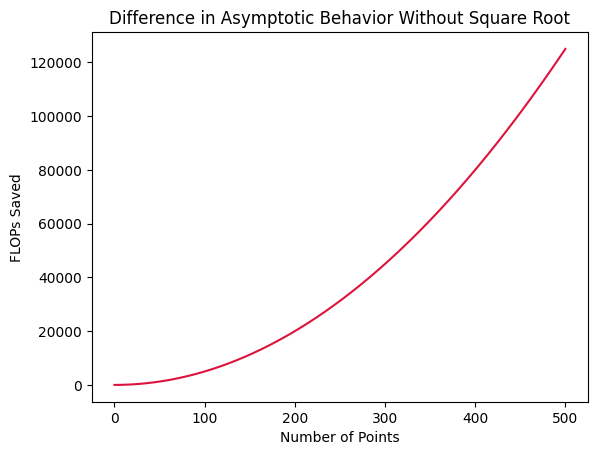

In [5]:
import matplotlib.pyplot as plt

x = np.linspace(0, 500, 500)
plt.xlabel('Number of Points')
plt.ylabel('FLOPs Saved')
plt.title('Difference in Asymptotic Behavior Without Square Root')
plt.plot(x, 0.5*x**2, color='#DC143C')
plt.show()

If you pass 500 points to `closest_pair_optimized`, you're saving over 120,000 FLOPs just by leaving out the square root.

In general, cutting out 120,000 FLOPs will always improve exeuction time, but to varying degrees, depending on the FLOPs removed. Square roots happen to be one of the most expensive floating point operations in terms of execution time, so cutting out 120,000 of them will probably speed things up significantly.

Let's test it out.

In [7]:
import time

points = np.random.randn(500, 2)

with_square_root_times = []
for k in range(20):
    start = time.time()
    closest_pair(points)
    end = time.time()
    with_square_root_times.append(end - start)
    
print(f'Average time with square root: {np.mean(with_square_root_times)}')

without_square_root_times = []
for k in range(20):
    start = time.time()
    closest_pair_optimized(points)
    end = time.time()
    without_square_root_times.append(end - start)
    
print(f'Average time without square root: {np.mean(without_square_root_times)}')

Average time with square root: 0.24490867853164672
Average time without square root: 0.11661527156829835


Removing the square root cuts the execution time _in half_! Both algorithms are $O(n^2)$, but one is much better than the other.

## Conclusion

In a world where every milisecond matters, it's worth caring about the leading order behavior of your algorithms. Even if you can't reduce an algorithm by an order of magnitude (e.g. $n^2$ to $n$), small improvements to the leading coefficient can result in drastic changes to execution time, creating a better experience for your users.

## Appendix

**Theorem** The main loop of the algorithm runs $\frac{1}{2}(n^2 - n)$ times.

Let's write the number of times the loop runs as a summation.

$$\sum_{k=0}^{n-1}\sum_{j=k+1}^{n-1}{1}$$

Let's first reduce the inner sum. The fundamental theorem of finite calculus states that

$$\sum_{k=a}^{b-1}{\Delta[f](k)} = f(b) - f(a)$$

Where $\Delta$ is the _finite difference operator_, defined by $\Delta[f](k) = f(k + 1) - f(k)$.

So, taking f(k) = k, we have $\Delta[f](k) = 1$, thus

$$\sum_{j=k+1}^{n-1}{1} = n - k - 1$$

by the fundamental theorem. Thus the summation above is reduced to

$$\sum_{k=0}^{n-1}{(n - k - 1)} = \sum_{k=0}^{n-1}{n} - \sum_{k=0}^{n-1}{k} - \sum_{k=0}^{n-1}{1} = n^2 - n - \sum_{k=0}^{n-1}{k}$$

There is a well-known formula that states that

$$\sum_{k=1}^{n}{k} = \frac{n(n + 1)}{2}$$

Using this, we have that 

$$\sum_{k=0}^{n-1}{k} = 0 + \sum_{k=1}^{n-1}{k} = \frac{n(n-1)}{2}$$

Continuing from above, this means that

$$\sum_{k=0}^{n-1}{(n - k - 1)} = n^2 - n - \frac{n(n-1)}{2} = \frac{n(n-1)}{2}$$

Which is equivalent to $\frac{1}{2}(n^2 - n)$. $\blacksquare$